The Poisson distribution is a statistical concept that may seem daunting at first, but it's actually quite straightforward once you break it down. In essence, it helps us understand and predict the probability of events occurring over a fixed period of time (or space), provided these events happen independently of each other and at a constant average rate. Let's delve into what this means, how it works with an example, and explore its applications in cybersecurity.


In [1]:
import numpy as np
import scipy.stats as stats
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Frequentist Approach

This part of the notebook performs the following steps:

- Historical Data: It starts with an array representing the number of incidents recorded each month over a year.
- Average Rate Calculation: It calculates the average rate (λ) of incidents per month from the historical data.
- Simulation: It simulates 10,000 instances of incident occurrences based on the Poisson distribution with the calculated average rate.
- Plotting: It plots the histogram of the simulated data to visualize the distribution of incidents. Then, it overlays the theoretical Poisson distribution calculated using the scipy.stats library for direct comparison, showing the match between the simulated data and theoretical expectations.

This approach allows you to visualize how well the Poisson distribution, with parameters estimated from historical data, models the distribution of future incidents, providing insights into the expected variability and frequency of incidents based on past trends.

In [2]:
# Historical data: number of events of interest per month for the past 12 months
historical_data = np.array([4, 5, 7, 3, 5, 6, 5, 4, 6, 5, 7, 4])

In [3]:
# Calculate the average rate (lambda) from historical data
lambda_rate = np.mean(historical_data)
lambda_rate

5.083333333333333

In [4]:
# Simulate Poisson distribution based on the calculated lambda
# Simulating for 10000 trials to get a good representation of the distribution
simulated_events = np.random.poisson(lambda_rate, 10000)

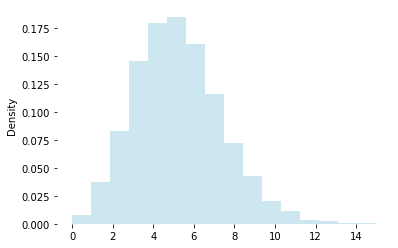

In [5]:
# Plotting the simulated distribution
# plt.hist(simulated_events, bins=range(np.min(simulated_events), np.max(simulated_events) + 1), density=True, alpha=0.6, color='lightblue')
sns.histplot(simulated_events, bins=np.max(simulated_events) - np.min(simulated_events) + 1, stat='density', alpha=0.6, color='lightblue', kde=False, edgecolor=None)
sns.despine(left=True, bottom=True)

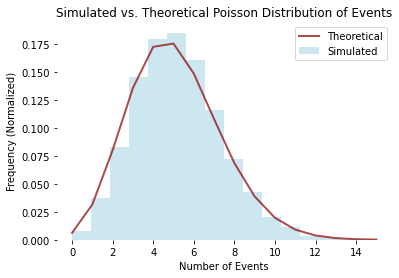

In [6]:
sns.histplot(simulated_events, bins=np.max(simulated_events) - np.min(simulated_events) + 1, stat='density', alpha=0.6, color='lightblue', kde=False, edgecolor=None)
# Overlay the theoretical Poisson distribution for comparison
# Use scipy.stats.poisson.pmf to calculate the probability mass function
events_range = np.arange(np.min(simulated_events), np.max(simulated_events) + 1)
theoretical_pmf = stats.poisson.pmf(events_range, lambda_rate)
plt.plot(events_range, theoretical_pmf, lw=2, color='darkred', linestyle='-', alpha=0.7)

plt.title('Simulated vs. Theoretical Poisson Distribution of Events')
plt.xlabel('Number of Events')
plt.ylabel('Frequency (Normalized)')
plt.legend(['Theoretical', 'Simulated'])

sns.despine(left=True, bottom=True)

I'd like to make the theoretical curve smoother, so I'll use a cubic spline interpolation. It's important to remember that making the curve "smoother" beyond a certain point does not necessarily provide additional insight into the data or the theoretical distribution, especially since the Poisson distribution is inherently discrete. That said, for visual or illustrative purposes, I think it looks nicer. Simply using a cubic spline interpolation doesn't make the curve "smooth" enough, so I'll increase the number of points in smooth_events_range used for plotting. This doesn't change the spline itself but provides a denser set of points on the curve, which can make the line appear smoother on the plot.

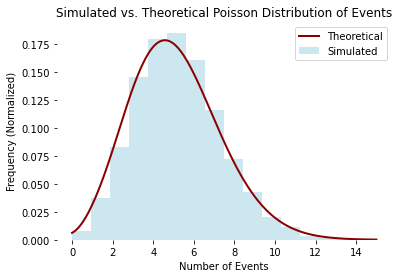

In [7]:
sns.histplot(simulated_events, bins=np.max(simulated_events) - np.min(simulated_events) + 1, stat='density', alpha=0.6, color='lightblue', kde=False, edgecolor=None)
# Overlay the theoretical Poisson distribution for comparison
# Use scipy.stats.poisson.pmf to calculate the probability mass function
events_range = np.arange(np.min(simulated_events), np.max(simulated_events) + 1)
theoretical_pmf = stats.poisson.pmf(events_range, lambda_rate)

# Interpolate a smooth curve
spl = make_interp_spline(events_range, theoretical_pmf, k=3)  # k=3 for cubic spline
# Increase the number of points for the cubic spline interpolation
smooth_events_range = np.linspace(events_range.min(), events_range.max(), 1000)  # More points
smooth_theoretical_pmf = spl(smooth_events_range)

plt.plot(smooth_events_range, smooth_theoretical_pmf, lw=2, color='darkred')
plt.title('Simulated vs. Theoretical Poisson Distribution of Events')
plt.xlabel('Number of Events')
plt.ylabel('Frequency (Normalized)')
plt.legend(['Theoretical', 'Simulated'])

sns.despine(left=True, bottom=True)

In [8]:
# Forecasting future events
# Probability of observing exactly 0, 3, and more than 10 events in a future month
prob_0_events = stats.poisson.pmf(0, lambda_rate)
prob_3_events = stats.poisson.pmf(3, lambda_rate)
prob_more_than_10_events = 1 - stats.poisson.cdf(10, lambda_rate)

In [9]:
# Analyze the likelihood of various scenarios to understand the risk profile
scenarios = np.arange(0, 21)  # Analyzing from 0 to 20 incidents
probabilities_scenarios = stats.poisson.pmf(scenarios, lambda_rate)

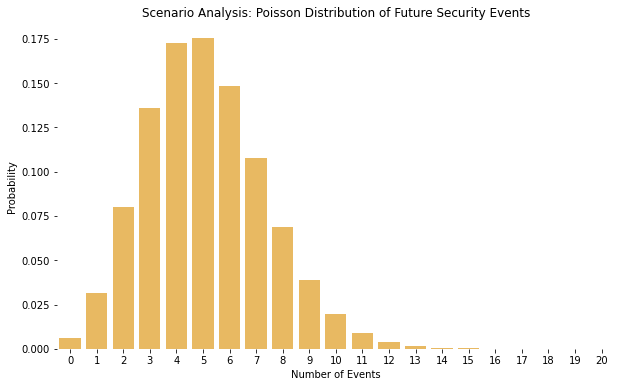

In [21]:
# Convert scenarios and probabilities_scenarios to a format suitable for Seaborn
data = {'Number of Events': scenarios, 'Probability': probabilities_scenarios}

# Create a DataFrame for easy plotting with Seaborn
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Number of Events', y='Probability', data=df, color='orange', alpha=0.7)

plt.title('Scenario Analysis: Poisson Distribution of Future Security Events')
plt.xlabel('Number of Events')
plt.ylabel('Probability')
sns.despine(left=True, bottom=True)
# Show the scenario analysis plot
plt.show()

In [11]:
# Display forecasted probabilities for specific scenarios
print(f"Probability of observing exactly 0 events: {prob_0_events:.4f}")
print(f"Probability of observing exactly 3 events: {prob_3_events:.4f}")
print(f"Probability of observing more than 10 events: {prob_more_than_10_events:.4f}")

Probability of observing exactly 0 events: 0.0062
Probability of observing exactly 3 events: 0.1357
Probability of observing more than 10 events: 0.0153


### Bayesian Approach

This part of the notebook does the following:

- Defines a Bayesian model with a Gamma prior for the Poisson rate parameter (λ) and a Poisson likelihood for observing the historical data.
- Samples from the posterior distribution of λ given the observed data, using PyMC3's sampling methods.
- Visualizes the posterior distribution of λ, providing insights into the most probable values of the event rate given the data and the prior.
- Generates and visualizes simulated future data (posterior predictive checks) based on the posterior estimates of λ. This step helps in understanding the implications of the posterior distribution for future event occurrences.

This Bayesian approach provides a probabilistic framework for understanding and predicting event occurrences, incorporating both prior beliefs and observed data.

In [12]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az

In [13]:
# Historical data: number of incidents per month for the past 12 months
historical_data = np.array([4, 5, 7, 3, 5, 6, 5, 4, 6, 5, 7, 4])

In [14]:
# Step 1: Define the Bayesian model
with pm.Model() as model:
    # Prior for λ: Gamma distribution (commonly used prior for Poisson rate parameter)
    lambda_prior = pm.Gamma('lambda', alpha=2.0, beta=0.1)
    
    # Likelihood of observed data: Poisson distribution
    observation = pm.Poisson('obs', mu=lambda_prior, observed=historical_data)
    
    # Step 2: Sample from the posterior distribution
    trace = pm.sample(1000, tune=500, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 37 seconds.
The acceptance probability does not match the target. It is 0.8817260319308221, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8826701322463429, but should be close to 0.8. Try to increase the number of tuning steps.


In the context of the Gamma distribution used as a prior in Bayesian models, the parameters α (often called the "shape" parameter) and β (often called the "rate" parameter in this context, but sometimes also referred to as the "inverse scale" parameter) play crucial roles in determining the distribution's shape and scale.

**Alpha (α) - Shape Parameter**
- Influence on Distribution: Determines the shape of the Gamma distribution. Higher values of α result in a more bell-shaped curve, while lower values lead to a more skewed distribution.
- Interpretation: Can be thought of as representing the number of events or observations. In many contexts, α is akin to the number of prior observations that inform the distribution.
**Beta (β) - Rate (or Inverse Scale) Parameter**
- Influence on Distribution: Influences the scale or rate of the distribution. Higher values of β result in a distribution that is more tightly concentrated around lower values, indicating a higher rate of occurrence per unit of measure. Lower values of β spread the distribution out, indicating a lower rate of occurrence.
- Interpretation: Can be thought of as the rate at which events occur, with higher values indicating a faster occurrence rate.

**The choice of α=2.0 and β=0.1 for the Gamma distribution has specific implications**

- α=2.0: This choice suggests that the prior belief incorporates the equivalent of observing two events. It's a relatively low value, indicating some uncertainty in the rate parameter λ, but not complete ignorance. It avoids the extreme skewness of distributions with α<1 and provides a modest amount of information to the model.
- β=0.1: This choice implies a belief in a relatively low rate of occurrence per unit time or space, stretching the distribution to allow for a wider range of possible values of λ. The low β value suggests that, prior to observing the data, we believe the rate of events (λ) to be distributed over a wide range, indicating substantial uncertainty about the precise rate but leaning towards lower frequencies.

In a Bayesian model, these choices for α and β reflect prior beliefs about the parameter λ before observing the data. Here, it implies a prior belief that the event rate is not precisely known but is expected to have a certain level of variability, with a tendency towards lower rates. The exact choice of these values should be informed by domain knowledge or previous observations. In practice, choosing α and β involves balancing between informative priors, which strongly guide the posterior based on prior knowledge, and non-informative or weakly informative priors, which allow the data to primarily inform the posterior distribution.

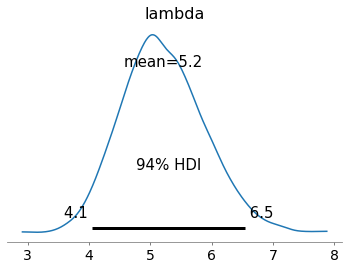

In [15]:
# Step 3: Visualize the posterior distribution of λ
az.plot_posterior(trace)
plt.show()

In [16]:
# Optional: Summary of the posterior distribution for λ
print(az.summary(trace, round_to=2))

        mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
lambda  5.21  0.67    4.05     6.55       0.02     0.01   1636.23   2629.78   

        r_hat  
lambda    1.0  


In [17]:
# Step 4: Predictive Posterior Checks - Simulate future data based on the posterior
with model:
    post_pred = pm.sample_posterior_predictive(trace, var_names=['lambda', 'obs'])
    post_pred_lambda = post_pred['lambda']

In [22]:
# Flatten the `post_pred['obs']` array to a 1D array for plotting
obs_flattened = post_pred['obs'].flatten()

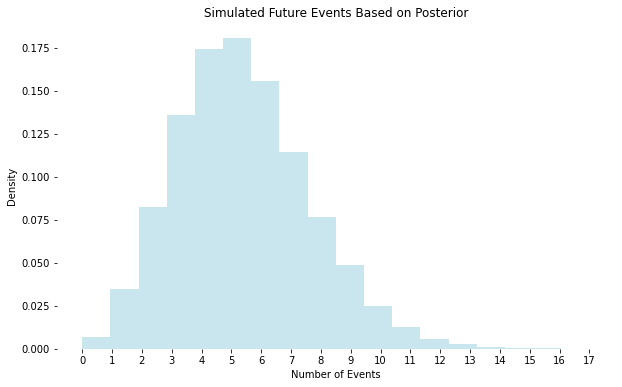

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(obs_flattened, bins=len(np.unique(obs_flattened)), stat='density', alpha=0.65, color='lightblue', edgecolor=None)

plt.title('Simulated Future Events Based on Posterior')
plt.xlabel('Number of Events')
plt.ylabel('Density')
# Set x-axis ticks to be integers
# Calculate the range of values on the x-axis
x_min, x_max = int(np.min(obs_flattened)), int(np.max(obs_flattened))
# Generate list of integers from x_min to x_max
x_ticks = np.arange(x_min, x_max + 1)
# Apply integers as x-tick labels
plt.xticks(x_ticks)
sns.despine(left=True, bottom=True)
plt.show()

In [19]:
# Assuming post_pred contains posterior predictive samples
observed_events = post_pred['obs']

# Calculate probabilities of specific scenarios based on the posterior predictive samples
prob_0_events = np.mean(observed_events == 0)
prob_3_events = np.mean(observed_events == 3)
prob_more_than_10_events = np.mean(observed_events > 10)

# Display forecasted probabilities for specific scenarios
print(f"Probability of observing exactly 0 events: {prob_0_events:.4f}")
print(f"Probability of observing exactly 3 events: {prob_3_events:.4f}")
print(f"Probability of observing more than 10 events: {prob_more_than_10_events:.4f}")

Probability of observing exactly 0 events: 0.0064
Probability of observing exactly 3 events: 0.1284
Probability of observing more than 10 events: 0.0212
